In [19]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statistics import fmean
import math
from tqdm import tqdm
import time
import pickle

from mplsoccer import Pitch, VerticalPitch

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay


from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import MinMaxScaler


In [2]:
from interpret import set_visualize_provider
from interpret.provider import InlineProvider
set_visualize_provider(InlineProvider())

In [3]:
tqdm.pandas()

# Carregando dados

In [4]:
frames_general = pd.read_csv('frames_general.csv')
frames_coords = pd.read_csv('frames_coords.csv')
spadl = pd.read_csv('spadl.csv')

In [23]:
spadl[spadl['type_id'] == 1]

,match_id,event_id,period_id,time_seconds,team_id,team_name,player_id,player_name,type_id,type_name,start_x,start_y,end_x,end_y,result_id,result_name,bodypart_id,bodypart_name
0,2128286,2253487625,1,0,90,Burnley,60551,Ashley Westwood,1,pass,52.815,34.204,32.025,34.204,1,success,1,foot
1,2128286,2253487639,1,2,90,Burnley,17761,James Tarkowski,1,pass,31.080,36.312,38.220,15.844,1,success,1,foot
2,2128286,2253487685,1,7,90,Burnley,68983,Matthew Lowton,1,pass,43.365,12.512,90.300,49.708,1,success,1,foot
5,2128286,2253488059,1,47,1,Manchester United,141746,Bruno Fernandes,1,pass,44.310,21.012,39.480,19.448,0,fail,1,foot
8,2128286,2253488079,1,50,90,Burnley,172782,Josh Brownhill,1,pass,45.465,13.464,63.000,53.516,0,fail,1,foot
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
521422,2128605,2287659557,2,5597,49,Sheffield United,109638,Kean Bryan,1,pass,56.280,66.028,48.930,63.580,1,success,1,foot
521423,2128605,2287659583,2,5600,49,Sheffield United,63426,Enda Stevens,1,pass,47.880,57.868,44.940,46.308,1,success,1,foot
521424,2128605,2287659613,2,5603,49,Sheffield United,79934,Oliver Norwood,1,pass,45.675,45.492,75.705,61.948,0,fail,1,foot
521430,2128605,2287660075,2,5672,49,Sheffield United,108416,John Egan,1,pass,37.485,35.428,78.960,66.028,1,success,1,foot


In [54]:
passes_spadl[passes_spadl['result_name'] == 'success'].sample(10)

,match_id,event_id,period_id,time_seconds,team_id,team_name,player_id,player_name,type_id,type_name,start_x,start_y,end_x,end_y,result_id,result_name,bodypart_id,bodypart_name
72439,2128471,2254985827,1,2268,14,Liverpool,61558,Thiago,1,pass,44.730,36.108,49.770,14.484,1,success,1,foot
495007,2128315,2216610189,1,2116,39,Wolverhampton Wanderers,171317,Rúben Neves,1,pass,79.380,17.204,91.665,4.352,1,success,1,foot
109381,2128363,2230203653,1,900,4,Newcastle United,179018,Miguel Almirón,1,pass,63.210,65.416,43.260,63.988,1,success,1,foot
254562,2128420,2246930037,2,3515,3,Arsenal,80201,Bernd Leno,1,pass,9.030,30.532,24.675,39.576,1,success,1,foot
271448,2128656,2302265379,2,4544,3,Arsenal,84450,Granit Xhaka,1,pass,47.460,27.064,59.955,27.064,1,success,1,foot
159236,2128419,2246651277,2,3886,31,Crystal Palace,232413,Eberechi Eze,1,pass,74.235,32.572,79.695,27.880,1,success,2,head
4495,2128323,2218689673,1,1398,90,Burnley,41674,Kevin Long,1,pass,41.475,1.768,33.495,39.984,1,success,1,foot
440739,2128505,2261328939,1,269,8,Chelsea,41328,César Azpilicueta,1,pass,35.385,9.928,40.425,15.368,1,success,1,foot
103690,2128304,2213427513,2,5694,20,Southampton,101178,James Ward-Prowse,1,pass,43.680,10.744,64.365,16.116,1,success,1,foot
277762,2128592,2285529711,1,1769,3,Arsenal,92371,Pablo Marí,1,pass,25.305,35.224,34.545,31.076,1,success,2,head


In [59]:
spadl.iloc[passes_spadl[passes_spadl['event_id'] == 2302265379].index[0]+1]['player_id']

54694

In [61]:
exemplo = frames_coords[frames_coords['event_id'] == 2302265379]
exemplo

,match_id,event_id,frame,team,team_status,x,x_opta,y_opta,y,vx,vy,accel_norm,speed_norm,player_id,player_position,player_with_event
9748512,2128656,2302265379,45750,3,offense,39.6259,39.6270,45.1316,45.1335,-0.0000,-0.0000,0.0000,0.0000,226597,LCB,False
9748513,2128656,2302265379,45750,36,defense,65.1185,65.1210,8.9556,8.9538,-0.0000,-0.0000,0.0000,0.0000,110735,RCB,False
9748514,2128656,2302265379,45750,3,offense,37.2263,37.2225,25.3708,25.3714,0.2524,0.0241,-0.3825,0.2535,156074,RCB,False
9748515,2128656,2302265379,45750,3,offense,59.5877,59.5875,41.7996,41.8018,0.6960,1.1787,0.0000,1.3688,223340,LW,False
9748516,2128656,2302265379,45750,3,offense,61.5412,61.5405,4.3180,4.3152,3.8340,0.8837,1.0380,3.9346,195735,RW,False
9748517,2128656,2302265379,45750,3,offense,46.6590,46.6620,6.3852,6.3827,-0.0245,0.5594,-0.4921,0.5600,101184,RWB,False
9748518,2128656,2302265379,45750,3,offense,44.6864,44.6880,38.2908,38.2921,-0.7836,2.3298,-0.5316,2.4581,167199,RM,False
9748519,2128656,2302265379,45750,36,defense,52.5283,52.5315,21.3384,21.3414,-1.4918,0.8853,0.2052,1.7347,227127,DM,False
9748520,2128656,2302265379,45750,36,defense,48.5810,48.5835,33.1228,33.1238,-0.2228,0.6659,-0.1944,0.7022,233425,CF,False
9748521,2128656,2302265379,45750,36,defense,53.7671,53.7705,10.6420,10.6401,0.7377,0.8336,-0.3713,1.1132,235382,LW,False


In [6]:
spadl['type_name'].value_counts()

type_name
pass                348795
bad_touch            25040
aerial_duel          24856
tackle               19019
throw_in             14879
clearance            14554
interception         13524
take_on              13444
cross                 9524
shot                  8710
freekick_short        7906
goalkick              5256
keeper_pick_up        4917
keeper_save           4781
corner_crossed        3164
freekick_crossed      1072
corner_short           686
keeper_claim           513
shot_freekick          359
keeper_punch           308
shot_penalty           125
Name: count, dtype: int64

In [7]:
passes_spadl = spadl[spadl['type_name'] == 'pass']

In [8]:
frames_coords['x'] = frames_coords['x']+52.5
frames_coords['y'] = frames_coords['y']+34
frames_coords['x_opta'] = frames_coords['x_opta']*(105/100)
frames_coords['y_opta'] = frames_coords['y_opta']*(68/100)

In [49]:
np.argmax(frames_coords['y'])

5254786

In [50]:
frames_coords.iloc[5254786]

match_id                2128482
event_id             2258205859
frame                     51790
team                         31
team_status             offense
x                       40.9526
x_opta                  40.4985
y_opta                   71.468
y                       71.4651
vx                      -0.4631
vy                      -0.8413
accel_norm               1.3971
speed_norm               0.9604
player_id                244723
player_position             LWB
player_with_event          True
Name: 5254786, dtype: object

In [51]:
spadl[spadl['event_id'] == 2258205859]

,match_id,event_id,period_id,time_seconds,team_id,team_name,player_id,player_name,type_id,type_name,start_x,start_y,end_x,end_y,result_id,result_name,bodypart_id,bodypart_name
179906,2128482,2258205859,2,5159,31,Crystal Palace,244723,Tyrick Mitchell,3,throw_in,35.07,68.0,23.625,55.76,1,success,1,foot


# Visualizações

## Visualização 1

In [70]:
passes_spadl.sample(6)

,match_id,event_id,period_id,time_seconds,team_id,team_name,player_id,player_name,type_id,type_name,start_x,start_y,end_x,end_y,result_id,result_name,bodypart_id,bodypart_name
153719,2128341,2225543615,2,4824,14,Liverpool,41733,Georginio Wijnaldum,1,pass,56.91,42.908,51.240,40.324,1,success,1,foot
193589,2128633,2296181555,2,3453,31,Crystal Palace,60252,Andros Townsend,1,pass,68.25,48.008,74.655,62.968,1,success,1,foot
422788,2128657,2302219701,1,496,8,Chelsea,228286,Édouard Mendy,1,pass,13.44,34.612,25.935,50.592,1,success,1,foot
448771,2128398,2243910715,2,3552,8,Chelsea,184341,Mason Mount,1,pass,72.24,60.928,74.130,46.172,0,fail,1,foot
78797,2128524,2264780693,1,401,1,Manchester United,214590,Aaron Wan-Bissaka,1,pass,72.45,5.644,82.740,2.924,1,success,1,foot
40287,2128587,2285196359,1,1817,90,Burnley,172782,Josh Brownhill,1,pass,68.04,32.368,67.935,11.220,1,success,1,foot


In [71]:
event_id_teste = 2225543615
event_test = spadl[spadl['event_id'] == event_id_teste]
frame_event_teste = frames_coords[frames_coords['event_id'] == event_id_teste]

In [72]:
event_test

,match_id,event_id,period_id,time_seconds,team_id,team_name,player_id,player_name,type_id,type_name,start_x,start_y,end_x,end_y,result_id,result_name,bodypart_id,bodypart_name
153719,2128341,2225543615,2,4824,14,Liverpool,41733,Georginio Wijnaldum,1,pass,56.91,42.908,51.24,40.324,1,success,1,foot


In [73]:
frame_event_teste

,match_id,event_id,frame,team,team_status,x,x_opta,y_opta,y,vx,vy,accel_norm,speed_norm,player_id,player_position,player_with_event
1481214,2128341,2225543615,58180,49,defense,73.7425,74.5815,45.3968,45.3999,-1.4848,0.6803,0.0000,1.6333,40386,RCB,False
1481215,2128341,2225543615,58180,14,offense,68.0638,68.6805,27.7440,27.7436,1.2175,1.3874,0.7519,1.8458,92217,AM,False
1481216,2128341,2225543615,58180,14,offense,51.4871,51.4500,40.3988,40.3981,-0.8469,1.0199,-1.0943,1.3256,56979,RM,False
1481217,2128341,2225543615,58180,14,offense,71.7633,72.5235,50.1024,50.1054,-0.0449,-0.6508,0.3948,0.6524,110979,LW,False
1481218,2128341,2225543615,58180,49,defense,72.6783,73.4790,51.1020,51.1000,-0.6972,0.6174,-3.2554,0.9313,82691,RWB,False
1481219,2128341,2225543615,58180,14,offense,61.0286,61.3620,19.8696,19.8688,0.4064,0.5962,0.9710,0.7216,194634,RW,False
1481220,2128341,2225543615,58180,49,defense,65.3399,65.8455,30.7496,30.7524,-0.0218,-0.0936,0.1713,0.0961,199598,DM,False
1481221,2128341,2225543615,58180,49,defense,61.3974,61.7505,41.9152,41.9170,-0.2814,-0.0504,-0.2823,0.2859,207189,RM,False
1481222,2128341,2225543615,58180,14,offense,60.0457,60.3435,65.7492,65.7493,-0.2913,0.8636,0.2022,0.9114,122798,LWB,False
1481223,2128341,2225543615,58180,14,offense,56.0100,56.1540,43.5676,43.5665,0.2497,-0.0428,0.3906,0.2533,41733,LM,True


56.91


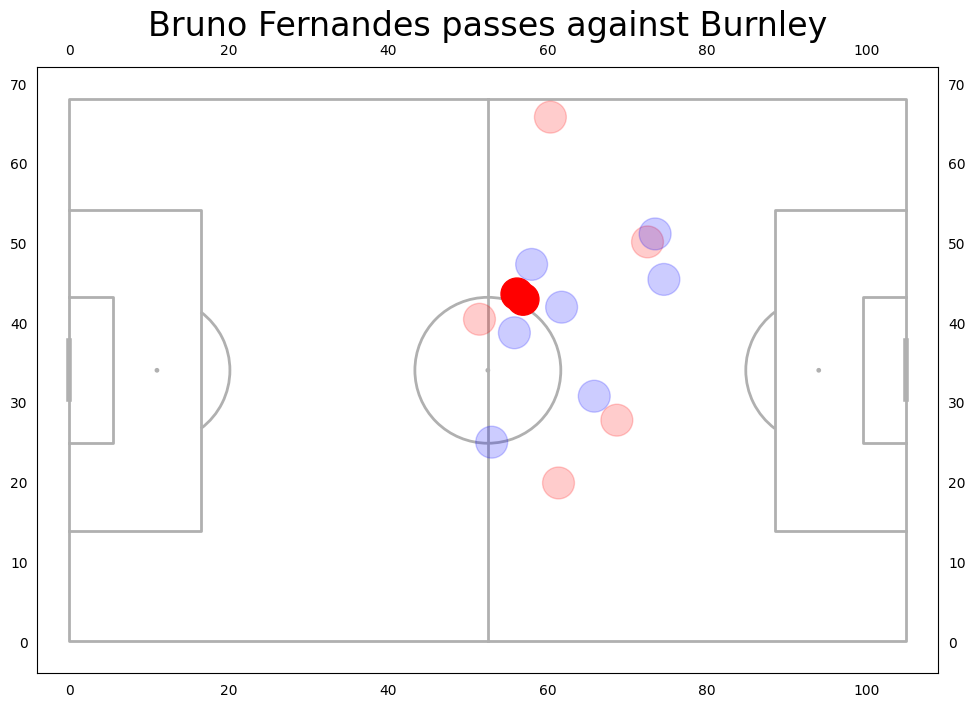

In [74]:
pitch = Pitch(pitch_type='uefa', pitch_length=105, pitch_width=68,  # example plotting a tracab pitch
              axis=True, label=True) 
fig, ax = pitch.draw(figsize=(10, 7))

x = event_test['start_x'].values[0]
print(x)
y = event_test['start_y'].values[0]
id_person = event_test['player_id'].values[0]
name_person = event_test['player_name'].values[0]

circle = plt.Circle((x,y),2,color="red")
circle.set_alpha(1)
ax.add_patch(circle)

for i,person in frame_event_teste.iterrows():
    #if pass made by Lucy Bronze
    if person['team_status'] == "offense":
        x=person['x_opta']
        y=person['y_opta']
        #plot circle
        circle = plt.Circle((x,y),2,color="red")
        if person['player_with_event'] == True:
            circle.set_alpha(1)
        else:
            circle.set_alpha(.2)
        ax.add_patch(circle)
    else:
        x=person['x_opta']
        y=person['y_opta']
        #plot circle
        circle = plt.Circle((x,y),2,color="blue")
        if person['player_with_event'] == True:
            circle.set_alpha(1)
        else:
            circle.set_alpha(.2)
        ax.add_patch(circle)

ax.set_title("Bruno Fernandes passes against Burnley", fontsize = 24)
fig.set_size_inches(10, 7)
plt.show()

## Visualização 2

In [17]:
passes_match_id = spadl[spadl['type_name'] == 'pass']
passes_match_id = passes_match_id[passes_match_id['match_id'] == 2128286]

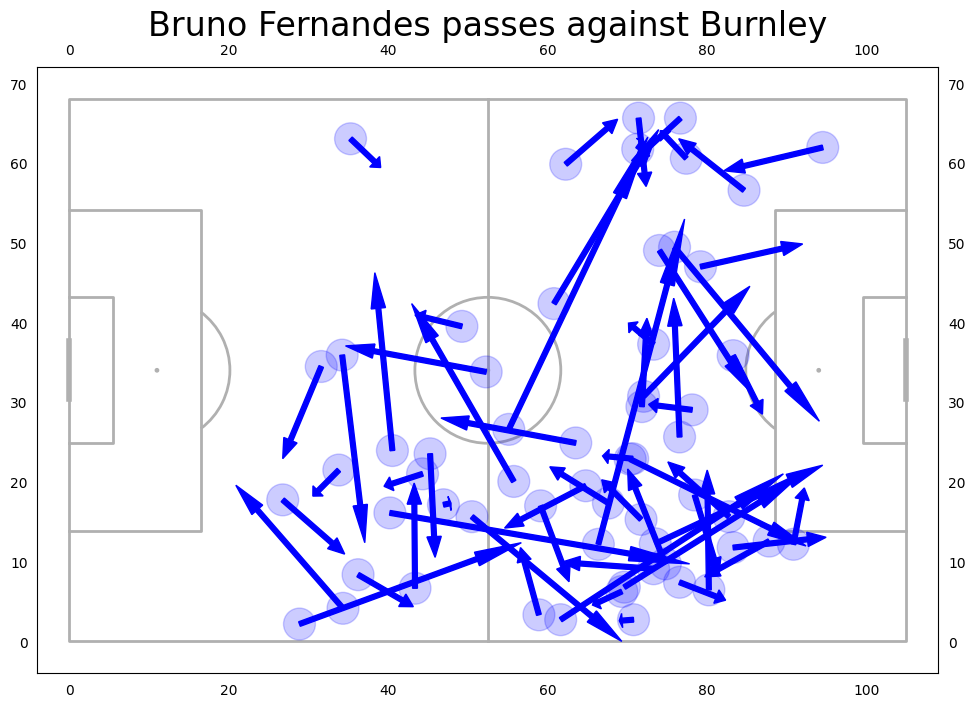

In [18]:
pitch = Pitch(pitch_type='uefa',  # example plotting a tracab pitch
              pitch_length=105, pitch_width=68,
              axis=True, label=True) 
fig, ax = pitch.draw(figsize=(10, 7))

for i,thepass in passes_match_id.iterrows():
    #if pass made by Lucy Bronze
    if thepass['player_name']=='Bruno Fernandes':
        x=thepass['start_x']
        y=thepass['start_y']
        #plot circle
        passCircle=plt.Circle((x,y),2,color="blue")
        passCircle.set_alpha(.2)
        ax.add_patch(passCircle)
        dx=thepass['end_x']-x
        dy=thepass['end_y']-y
        #plot arrow
        passArrow=plt.Arrow(x,y,dx,dy,width=3,color="blue")
        ax.add_patch(passArrow)

ax.set_title("Bruno Fernandes passes against Burnley", fontsize = 24)
fig.set_size_inches(10, 7)
plt.show()

## Visualização 3

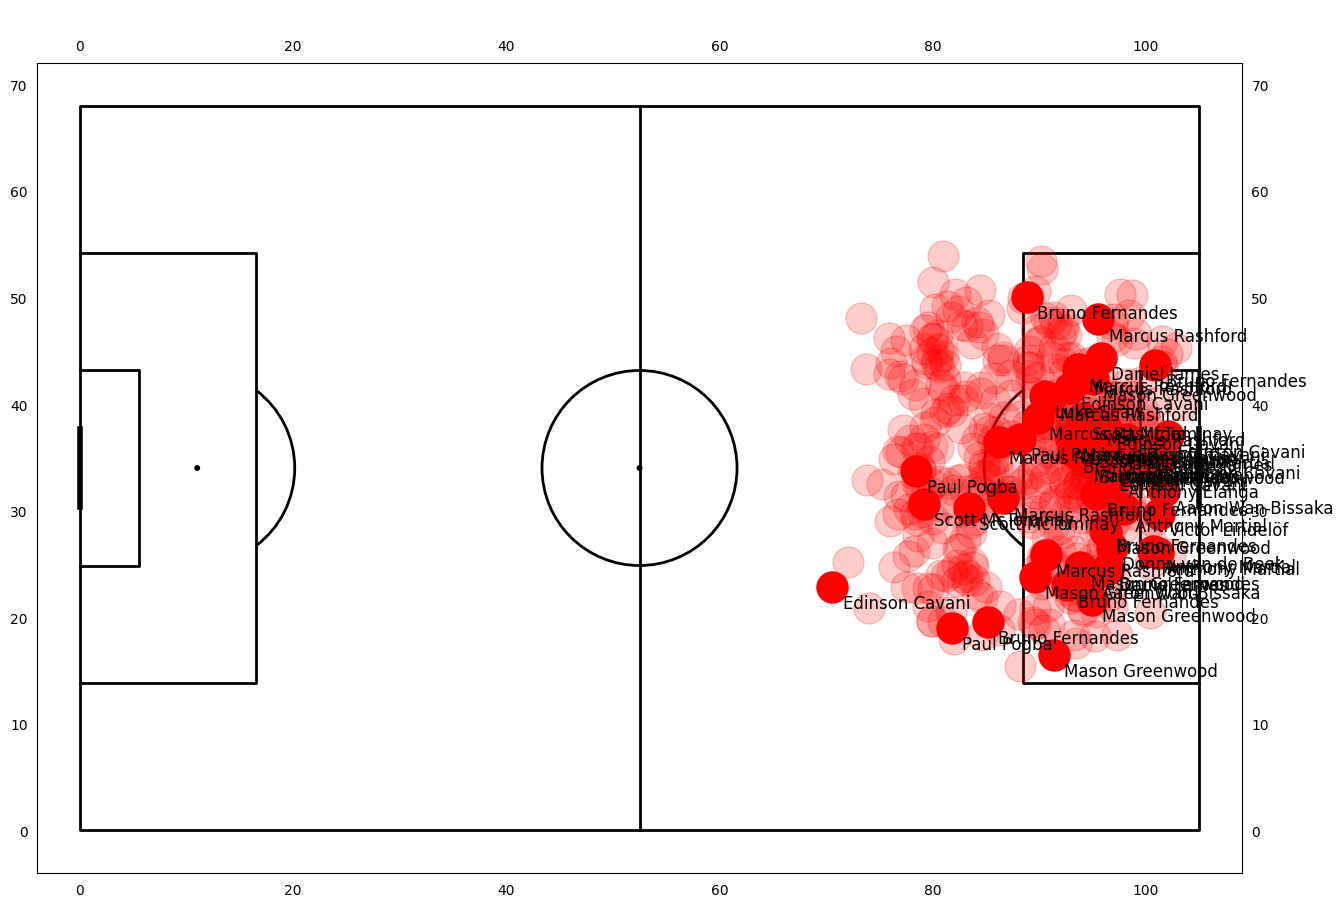

In [20]:
#create pitch
pitch = Pitch(line_color='black', pitch_type='uefa', pitch_length=105, pitch_width=68, axis=True, label=True)
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
#query
mask_england = (spadl.type_name == 'shot') & (spadl.team_name == 'Manchester United')
#finding rows in the df and keeping only necessary columns
df_england = spadl.loc[mask_england, ['start_x', 'start_y', 'result_name', "player_name"]]

#plot them - if shot ended with Goal - alpha 1 and add name
#for England
for i, row in df_england.iterrows():
    if row["result_name"] == 'success':
    #make circle
       pitch.scatter(row.start_x, row.start_y, alpha = 1, s = 500, color = "red", ax=ax['pitch'])
       pitch.annotate(row["player_name"], (row.start_x + 1, row.start_y - 2), ax=ax['pitch'], fontsize = 12)
    else:
       pitch.scatter(row.start_x, row.start_y, alpha = 0.2, s = 500, color = "red", ax=ax['pitch'])

# Pré-processamento

## Event data

### Dicionário de jogadores, times e parte do corpo

In [9]:
passes_spadl_model = passes_spadl.copy(deep=True)

In [10]:
players_dict = dict()
teams_dict = dict()
bodypart_dict = dict()

In [11]:
def check_player(x):
    if x['player_id'] in players_dict.keys():
        pass
    else:
        players_dict[x['player_id']] = x['player_name']

def check_team(x):
    if x['team_id'] in teams_dict.keys():
        pass
    else:
        teams_dict[x['team_id']] = x['team_name']

def check_bodypart(x):
    if x['bodypart_id'] in teams_dict.keys():
        pass
    else:
        teams_dict[x['bodypart_id']] = x['bodypart_name']

In [12]:
spadl.apply(check_player, axis=1)
spadl.apply(check_team, axis=1)
spadl.apply(check_bodypart, axis=1);

### Calcular distância e ângulo do passe

In [13]:
def distancia2d(x1, y1, x2, y2):
    a = x2 - x1
    b = y2 - y1
    c = math.sqrt(math.pow(a, 2) + math.pow(b, 2))
    return c

In [14]:
def angle_cos(xi,xf,d):
    cat_adj = xf-xi
    hip = d
    if hip == 0:
        hip=1
    cos = cat_adj/hip
    ang_in_radians = math.acos(cos)
    return ang_in_radians

In [15]:
passes_spadl_model['distance'] = [distancia2d(passe['start_x'], passe['start_y'], passe['end_x'], passe['end_y']) for i, passe in passes_spadl_model.iterrows()]

In [16]:
passes_spadl_model['angle'] = [angle_cos(passe['start_x'], passe['end_x'], passe['distance']) for i, passe in passes_spadl_model.iterrows()]

### Evento anterior

In [17]:
evento_anterior = []
#evento_2_anterior = []
#evento_3_anterior = []
#evento_4_anterior = []
#evento_5_anterior = []
for i, row in passes_spadl_model.iterrows():
    #if spadl.iloc[i-1]['type_name'] == 'pass' and spadl.iloc[i-1]['result_name'] == 'success':
    evento_anterior.append(spadl.iloc[i-1]['type_name'])
    #evento_2_anterior.append(spadl.iloc[i-2]['type_name'])
    #evento_3_anterior.append(spadl.iloc[i-3]['type_name'])
    #evento_4_anterior.append(spadl.iloc[i-4]['type_name'])
    #evento_5_anterior.append(spadl.iloc[i-5]['type_name'])

In [18]:
passes_spadl_model['previous_event_type'] = evento_anterior
#passes_spadl_model['2_previous_event_type'] = evento_2_anterior
#passes_spadl_model['3_previous_event_type'] = evento_3_anterior
#passes_spadl_model['4_previous_event_type'] = evento_4_anterior
#passes_spadl_model['5_previous_event_type'] = evento_5_anterior

## Tracking data

### Pressão ao passador

In [147]:
numpy_frames_coords_event_id = frames_coords['event_id'].values

def check_distance_tracking(row, x_player, y_player, team_player):
    if row['team'] == team_player:
        return np.inf
    else:
        return distancia2d(x_player, y_player, row['x'], row['y'])

def check_close_players(row):
    #inicio = time.time()
    pass_tracking = frames_coords[numpy_frames_coords_event_id == row['event_id']]
    #inicio_meio = time.time()
    player_with_event_tracking = pass_tracking[pass_tracking['player_with_event'].values == True]
    #meio = time.time()
    if len(player_with_event_tracking['x']) == 1:
        x_player = player_with_event_tracking['x'].values[0]
        y_player = player_with_event_tracking['y'].values[0]
        team_player = player_with_event_tracking['team'].values[0]
        
        distance = pass_tracking.apply(check_distance_tracking, args=(x_player, y_player, team_player), axis=1).values
        #meio_fim = time.time()

        close_distances = [i for i in distance if i<=5]

        num_perto = len(close_distances)   #Número de adversários perto do passador

        if num_perto>0:        
            mean_distance_lower = fmean(close_distances)
            closest = np.min(close_distances)
            #fim = time.time()
            #print(fim-meio_fim,meio_fim-meio,meio-inicio_meio, inicio_meio-inicio)
            return (num_perto, mean_distance_lower, closest)
        else:
            return (0,0,0)
    else:
        return 0

In [ ]:
passer_file_name = 'passer.pkl'

if os.path.isfile(passer_file_name):
    with open(passer_file_name, 'rb') as f:
        passer_contested = pickle.load(f)
else:
    distance_all = passes_spadl_model.progress_apply(check_close_players, axis=1)
    passer_contested = distance_all.values

    with open(passer_file_name, 'wb') as f:
        pickle.dump(passer_contested, f)

In [38]:
n_close_players = [i[0] if type(i)!=int else 0 for i in passer_contested]
close_players_mean_distance = [1/i[1] if (type(i)!=int and i[1]!=0) else 0 for i in passer_contested]
closest_player_distance = [1/i[2] if (type(i)!=int and i[2]!=0) else 0 for i in passer_contested]

In [39]:
passes_spadl_model['n_close_players'] = n_close_players
passes_spadl_model['close_players_mean_distance'] = close_players_mean_distance
passes_spadl_model['closest_player_distance'] = closest_player_distance

### Pressão ao receptor

In [ ]:
passes_spadl['end_x']

In [ ]:
numpy_frames_coords_event_id = frames_coords['event_id'].values

def check_distance_tracking(row, x_player, y_player, team_player):
    if row['team'] == team_player:
        return np.inf
    else:
        return distancia2d(x_player, y_player, row['x'], row['y'])

def check_close_players(row):
    #inicio = time.time()
    pass_tracking = frames_coords[numpy_frames_coords_event_id == row['event_id']]
    #inicio_meio = time.time()
    player_with_event_tracking = pass_tracking[pass_tracking['player_with_event'].values == True]
    #meio = time.time()
    if len(player_with_event_tracking['x']) == 1:
        x_player = player_with_event_tracking['x'].values[0]
        y_player = player_with_event_tracking['y'].values[0]
        team_player = player_with_event_tracking['team'].values[0]
        
        distance = pass_tracking.apply(check_distance_tracking, args=(x_player, y_player, team_player), axis=1).values
        #meio_fim = time.time()

        close_distances = [i for i in distance if i<=5]

        num_perto = len(close_distances)   #Número de adversários perto do passador

        if num_perto>0:        
            mean_distance_lower = fmean(close_distances)
            closest = np.min(close_distances)
            #fim = time.time()
            #print(fim-meio_fim,meio_fim-meio,meio-inicio_meio, inicio_meio-inicio)
            return (num_perto, mean_distance_lower, closest)
        else:
            return (0,0,0)
    else:
        return 0

In [ ]:
passer_file_name = 'receiver.pkl'

if os.path.isfile(passer_file_name):
    with open(passer_file_name, 'rb') as f:
        passer_contested = pickle.load(f)
else:
    distance_all = passes_spadl_model.progress_apply(check_close_players, axis=1)
    passer_contested = distance_all.values

    with open(passer_file_name, 'wb') as f:
        pickle.dump(passer_contested, f)

In [ ]:
n_close_players = [i[0] if type(i)!=int else 0 for i in passer_contested]
close_players_mean_distance = [1/i[1] if (type(i)!=int and i[1]!=0) else 0 for i in passer_contested]
closest_player_distance = [1/i[2] if (type(i)!=int and i[2]!=0) else 0 for i in passer_contested]

In [ ]:
passes_spadl_model['n_close_players'] = n_close_players
passes_spadl_model['close_players_mean_distance'] = close_players_mean_distance
passes_spadl_model['closest_player_distance'] = closest_player_distance

### Interceptação ao passe

## Preparando para o modelo

### X e y

In [68]:
y = passes_spadl_model['result_id'].values
#passes_spadl_model = passes_spadl_model[['bodypart_id', 'distance', 'angle', 'previous_event_type', '2_previous_event_type', '3_previous_event_type', '4_previous_event_type', '5_previous_event_type', 'close_players']]
#passes_spadl_model = passes_spadl_model[['bodypart_id', 'distance', 'angle', 'previous_event_type', '2_previous_event_type', '3_previous_event_type']]
passes_spadl_model = passes_spadl_model[['bodypart_id', 'distance', 'angle', 'n_close_players', 'close_players_mean_distance', 'closest_player_distance']]

### Treino e teste

In [70]:
X_train, X_test, y_train, y_test = train_test_split(passes_spadl_model, y, test_size=0.1, random_state=42)

### Min-max scaling

In [71]:
mms = MinMaxScaler()

#passes_spadl_model[['distance','angle', 'close_players']] = mms.fit_transform(passes_spadl_model[['distance', 'angle', 'n_close_players']])
#print(mms.fit_transform(passes_spadl_model[['distance', 'angle', 'n_close_players']]))

X_train[['distance','angle','n_close_players','close_players_mean_distance','closest_player_distance']] = mms.fit_transform(X_train[['distance','angle','n_close_players','close_players_mean_distance','closest_player_distance']])
X_test[['distance','angle','n_close_players','close_players_mean_distance','closest_player_distance']] = mms.transform(X_test[['distance','angle','n_close_players','close_players_mean_distance','closest_player_distance']])

### OneHotEncoding

In [72]:
#columnTransformer = ColumnTransformer([('encoder', OneHotEncoder(sparse=False), [0, 3, 4, 5, 6, 7])], remainder='passthrough')
#columnTransformer = ColumnTransformer([('encoder', OneHotEncoder(sparse=False), [0, 3, 4, 5])], remainder='passthrough')
columnTransformer = ColumnTransformer([('encoder', OneHotEncoder(sparse=False), [0])], remainder='passthrough')
X_train = np.array(columnTransformer.fit_transform(X_train))
X_test = np.array(columnTransformer.transform(X_test))

e:\Desktop\Henrique\8_PERIODO\CDAF\.venv\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning:

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.



# Modelos

In [ ]:
positive_class = len(passes_spadl[passes_spadl['result_id'] == 1])
negative_class = len(passes_spadl[passes_spadl['result_id'] == 0])

## Regressão logística

### Treino

In [73]:
lr_model = LogisticRegression()

In [74]:
lr_model.fit(X_train, y_train)

LogisticRegression()

### Avaliação

In [75]:
lr_model.score(X_train, y_train)

0.8445948744086775

In [76]:
lr_model.score(X_test, y_test)

0.8454128440366973

In [77]:
roc_auc_score(y_test, lr_model.predict_proba(X_test)[:, 1])

0.8048707071033498

## XGBoost

### Treino

In [ ]:
#scale_pos_weight=negative_class/positive_class

In [78]:
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

### Avaliação

In [79]:
# make predictions for test data
y_pred_test = model.predict(X_test)
predictions_test = [round(value) for value in y_pred_test]

y_pred_train = model.predict(X_train)
predictions_train = [round(value) for value in y_pred_train]

In [80]:
# evaluate predictions
accuracy = accuracy_score(y_train, predictions_train)
print("Accuracy: %.3f%%" % (accuracy * 100.0))

# evaluate predictions
accuracy = accuracy_score(y_test, predictions_test)
print("Accuracy: %.3f%%" % (accuracy * 100.0))

Accuracy: 87.438%
Accuracy: 86.700%


In [81]:
precision = precision_score(y_test, predictions_test)
print("precision: %.3f%%" % (precision * 100.0))

precision: 89.797%


In [82]:
recall = recall_score(y_test, predictions_test)
print("recall: %.3f%%" % (recall * 100.0))

recall: 94.567%


In [83]:
auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
print("auc: %.3f%%" % (auc * 100.0))

auc: 87.142%


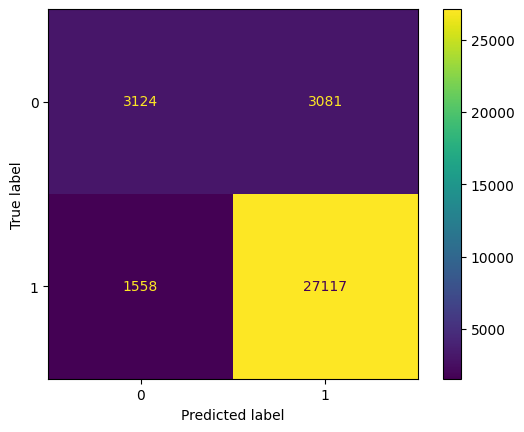

In [84]:
cm = confusion_matrix(y_test, predictions_test, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()

## Explainable Boosting Machine

### Treino

In [85]:
ebm = ExplainableBoostingClassifier()

In [86]:
ebm.fit(X_train, y_train)

ExplainableBoostingClassifier()

### Avaliação

In [87]:
# make predictions for test data
y_pred_test = ebm.predict(X_test)
predictions_test = [round(value) for value in y_pred_test]

y_pred_train = ebm.predict(X_train)
predictions_train = [round(value) for value in y_pred_train]

In [88]:
# evaluate predictions
accuracy = accuracy_score(y_train, predictions_train)
print("Accuracy: %.3f%%" % (accuracy * 100.0))

# evaluate predictions
accuracy = accuracy_score(y_test, predictions_test)
print("Accuracy: %.3f%%" % (accuracy * 100.0))

Accuracy: 86.710%
Accuracy: 86.735%


In [89]:
auc = roc_auc_score(y_test, ebm.predict_proba(X_test)[:, 1])
print("AUC: {:.3f}".format(auc))

AUC: 0.870


In [91]:
X_train.shape

(313915, 8)

In [90]:
show(ebm.explain_global())